### CT421

### Assignment1 PartB

##### Yiheng Jiang 19280059

In [73]:
# import useful packages
import random
from csv import reader
import matplotlib.pyplot as plt
import copy

### Data Processing

In [74]:
# initialize a student list and a lecturer list
students_list = []
lecturers_list = []

# read in the tables and instantiate some students and lecturers lists
with open('Student-choices.csv', 'r') as stu_file:
    stu_reader = reader(stu_file)
    for line in stu_reader:
        #create a list that stands for student
        preference_list = []
        for n in range(1, len(line)):
            preference_list.append(int(line[n]))
        students_list.append(preference_list)

with open('Supervisors.csv', 'r') as lec_file:
    lec_reader = reader(lec_file)
    for line in lec_reader:
        #create a list that stands for lecturer
        lecturer = []
        for n in range(int(line[1])):
            #each list in the lecturer list stands for a student slot
            lecturer.append([])
        lecturers_list.append(lecturer)
        
random.seed(45)

### Configurations & Experiment

In [75]:
# this function is used to calculate the sum of preference
# of a fully assigned list of lecturer
def sum_of_preference(list_of_all_assigned_lecturer):
    index_lecturer = 0
    sum_score = 0
    for lecturer in list_of_all_assigned_lecturer:#get the lecturer
        for assigned_stu in lecturer:#get the student
            sum_score += int(assigned_stu[index_lecturer])
        index_lecturer += 1
    return sum_score

In [76]:
# this is a helper function, used to remove a list (student)
# from another list of students, based on whether if the
# values are the same
def remove_student(source_list, student_to_remove):
    for source_student in source_list:
        if(source_student == student_to_remove):
            source_list.remove(student_to_remove)
            break;
    return copy.deepcopy(source_list)

In [77]:
# this is the fitness function
# as the sum of preference score(in an individual) is in
# range around [46, 1012]
# take the inverse of this number then multiply by 46
# as the fitness score, so the fitness score is ranged
# from [1/22, 1]. the closer to 1, the better the model
def fitness_func(list_of_all_assigned_lecturer):
    sum_of_pre = sum_of_preference(list_of_all_assigned_lecturer)
    fitness = 46 / sum_of_pre
    return fitness

In [78]:
# this is a function to perform a one point crossover
def one_point_crossover(parent1, parent2, full_student_list):
    crossover_point = random.randint(0, len(parent1))
    child1 = []
    # from the crossover point, take the left indexes from parent1,
    # right indexes from parent 2. the left part are maintained
    # compeletely, while the right part will try to maintain itself
    # as much as possible, by keeping all the students that did not
    # show up in the left part and at last, randomly assigned the
    # leftover students to the right part
    
    student_leftovers = copy.deepcopy(full_student_list) #used to check if student is left
    student_assigned = [] #used to check assigned student
    
    for n in range(crossover_point):
        # take indexes before crossover point from parent1
        child1.append(parent1[n])
        for stu in parent1[n]:
            # add this student to assigned list while remove it from
            # leftovers list
            student_leftovers = remove_student(student_leftovers, stu)
            student_assigned.append(stu)
    
    # now, add all the leftovers to the empty slots of the right part, with
    # a random order. this is to avoid a repetitive assigned situation
    random.shuffle(student_leftovers)
    
    right_part = [] #this is the right part (lecturers) [[[], []], [[]]]
    
    # now the left part of the child is constructed, proceed to right part
    for m in range(crossover_point, len(parent1)):
        the_lecturer = copy.deepcopy(parent2[m]) #[[], [], []]
        new_assigned_lecturer = []
        for student in the_lecturer: #[]
            if(student in student_assigned):
                # if this student is already assigned, append a student from leftover list
                new_assigned_lecturer.append(student_leftovers[0])
                student_leftovers = remove_student(student_leftovers, student_leftovers[0]) #remove it
            else:
                new_assigned_lecturer.append(student)
                student_leftovers = remove_student(student_leftovers, student)
                student_assigned.append(student)
        right_part.append(new_assigned_lecturer)

    # now build another child using the left part of parent2 and right part of parent 1
    student_leftovers = copy.deepcopy(full_student_list) #used to check if student is left
    student_assigned = [] #used to check assigned student
    child2 = []
    
    for o in range(crossover_point):
        # take indexes before crossover point from parent2
        child2.append(parent2[o])
        for stu in parent2[o]:
            # add this student to assigned list while remove it from
            # leftovers list
            student_leftovers = remove_student(student_leftovers, stu)
            student_assigned.append(stu)
    
    random.shuffle(student_leftovers)
    right_part2 = []
    
    for p in range(crossover_point, len(parent1)):
        the_lecturer = copy.deepcopy(parent1[p]) #[[], [], []]
        new_assigned_lecturer = []
        for student in the_lecturer: #[]
            if(student in student_assigned):
                # if this student is already assigned, append a student from leftover list
                new_assigned_lecturer.append(student_leftovers[0])
                student_leftovers = remove_student(student_leftovers, student_leftovers[0]) #remove it
            else:
                new_assigned_lecturer.append(student)
                student_leftovers = remove_student(student_leftovers, student)
                student_assigned.append(student)
        right_part2.append(new_assigned_lecturer)
    
    return child1 + right_part, child2 + right_part2

In [79]:
# this is a function to perform a standard mutation
# the mutation probability is set to 1/number of students
# randomly swapping two students in two randomly chosen lecturers
def starndard_mutation(child, full_student_list):
    mutation_probability = 1/len(full_student_list)
    for lecturers in child: #[[], [], []]
        for student in lecturers: #[]
            if(random.random() < mutation_probability):
                studentA = student #record the student reference
                # find a random student B
                b_index = random.randint(0, len(full_student_list) - 1)
                curr_index = -1
                for lec in child:
                    for stu in lec:
                        curr_index += 1
                        if(curr_index == b_index):
                            # swap these two students
                            studentB = stu
                            studentA, studentB = studentB, studentA
    return child

In [80]:
# define an initial population
population = []

# used to plot the fitness
fitness_scores = []
preference_scores = []

# configurations
population_size = 80
generation = 50
elite_size = 4
reproduction_size = int((population_size - elite_size) / 2)

# generate an initial population
for n in range(population_size):
    # clone a new list of students and empty lecturers
    new_lecturers_list = copy.deepcopy(lecturers_list)
    new_students_list = copy.deepcopy(students_list)
    
    # randomly assign students
    for lec in new_lecturers_list:# an exmaple lec [[], []]
        for lec_index in range(len(lec)):# an example len(lec): 2
            stu_index = random.randint(0, len(new_students_list) - 1)
            # assign the stu to lec, remove stu from list
            lec[lec_index] = copy.deepcopy(new_students_list[stu_index])
            new_students_list = copy.deepcopy(remove_student(new_students_list, new_students_list[stu_index]))
    population.append(copy.deepcopy(new_lecturers_list))

# run the experiment
for m in range(generation):
    population_ordered = copy.deepcopy(sorted(population, key=fitness_func, reverse=True))
    elite = copy.deepcopy(population_ordered[:elite_size])
    # reproduction process:
    children = []
    population = []
    for o in range(reproduction_size):
        parent1 = random.choice(elite)
        parent2 = random.choice(elite)
        child1, child2 = one_point_crossover(copy.deepcopy(parent1), copy.deepcopy(parent2), copy.deepcopy(students_list))
        child1 = starndard_mutation(copy.deepcopy(child1), copy.deepcopy(students_list))
        child2 = starndard_mutation(copy.deepcopy(child2), copy.deepcopy(students_list))
        children.append(copy.deepcopy(child1))
        children.append(copy.deepcopy(child2))
    # generate a new population of children and parents
    population = copy.deepcopy(children) + copy.deepcopy(elite)
    # append avg fitness and avg sum of preference to list
    fitness_score = 0
    preference_score = 0
    for p in range(population_size):
        fitness_score += (fitness_func(population[p]) / population_size)
        preference_score += (sum_of_preference(population[p]) / population_size)
    fitness_scores.append(fitness_score)
    preference_scores.append(preference_score)

# get the best result from the last generation
best_individual = population[0]
best_fitness = fitness_func(best_individual)
best_preference = sum_of_preference(best_individual)

### Plot the Results:

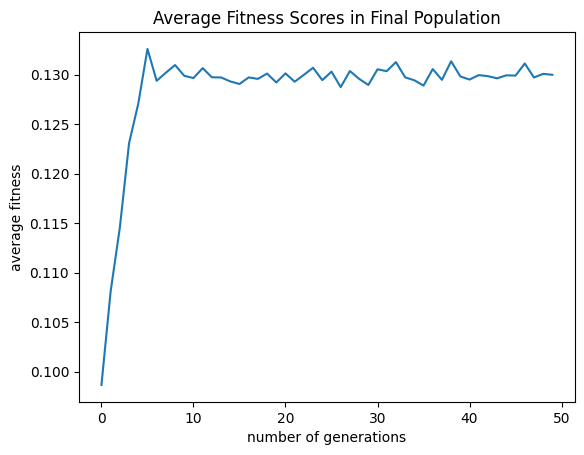

In [81]:
# plot the result
plt.plot(fitness_scores)
plt.title("Average Fitness Scores in Final Population")
plt.xlabel("number of generations")
plt.ylabel("average fitness")
plt.show()

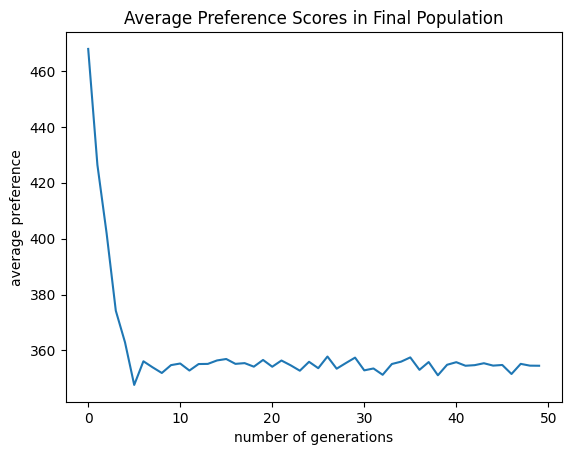

In [82]:
# plot the result
plt.plot(preference_scores)
plt.title("Average Preference Scores in Final Population")
plt.xlabel("number of generations")
plt.ylabel("average preference")
plt.show()

In [83]:
print("The best result of total generations is with fitness score of: " + str(best_fitness))
print("The best result of total generations is with sum of preference score of: " + str(best_preference))

The best result of total generations is with fitness score of: 0.14420062695924765
The best result of total generations is with sum of preference score of: 319


# Conclusions see report!